# 2nd Derivative weighted loss function

Notebook exploring the development of a loss function that is weighted based on the second derivative.  

The second derivative has a large negative value at the stick -> slip transition and large positive value at the slip -> stick transition. A loss function weighted by the second derivative (with possible seperate weightings dependent on whether it is positive or negative) should help any ML model to prioritise learning to accurately forecast start and end of failures.

## Setup

In [1]:
# Import libraries
import sys
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch
import json
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Import local modules
from utils.dataset import SlowEarthquakeDataset
import utils.general_functions as gfn
from utils.data_preprocessing import moving_average_causal_filter, create_dataset, normalise_dataset

In [3]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load data

In [4]:
# Define experiment list
EXPERIMENTS = [
    "cascadia",
    "p4679",
    "p4581",
    "b726",
    "b698",
    "i417",
    "sim_b726",
    "sim_b698",
    "sim_i417",
]

# Initialize the dataset loader with all experiments and load the data
dataset_loader = SlowEarthquakeDataset(EXPERIMENTS)
dataset_loader.load()

# Store all datasets in a single dataframe
df = {
    exp: dataset_loader.convert_to_df(exp)
    .rename(columns={"seg_avg" if exp == "cascadia" else "obs_shear_stress": "X"})[["X"]]
    for exp in EXPERIMENTS
}

## Standardised data pre-processing

### Downsampling and smoothing

In [5]:
# Get standardised downsampling and smoothing factors
with open("../conf.json", "r") as f:
    config = json.load(f)

config


{'cascadia': {'smoothing_window': 10, 'downsampling_factor': 1},
 'p4679': {'smoothing_window': 13, 'downsampling_factor': 13},
 'p4581': {'smoothing_window': 26, 'downsampling_factor': 26},
 'b726': {'smoothing_window': 1, 'downsampling_factor': 1},
 'b698': {'smoothing_window': 2, 'downsampling_factor': 2},
 'i417': {'smoothing_window': 2, 'downsampling_factor': 2},
 'sim_b726': {'smoothing_window': 1, 'downsampling_factor': 1},
 'sim_b698': {'smoothing_window': 2, 'downsampling_factor': 2},
 'sim_i417': {'smoothing_window': 2, 'downsampling_factor': 2}}

In [6]:
# Smooth and downsample
df_filtered = {
    exp: moving_average_causal_filter(df[exp], **config[exp])
    for exp in EXPERIMENTS
}

### Scaling

In [7]:
# Data scaling
scaler = MinMaxScaler()

df_filtered_sc = {
    exp: scaler.fit_transform(df_filtered[exp])
    for exp in EXPERIMENTS
}

### Visualise datasets

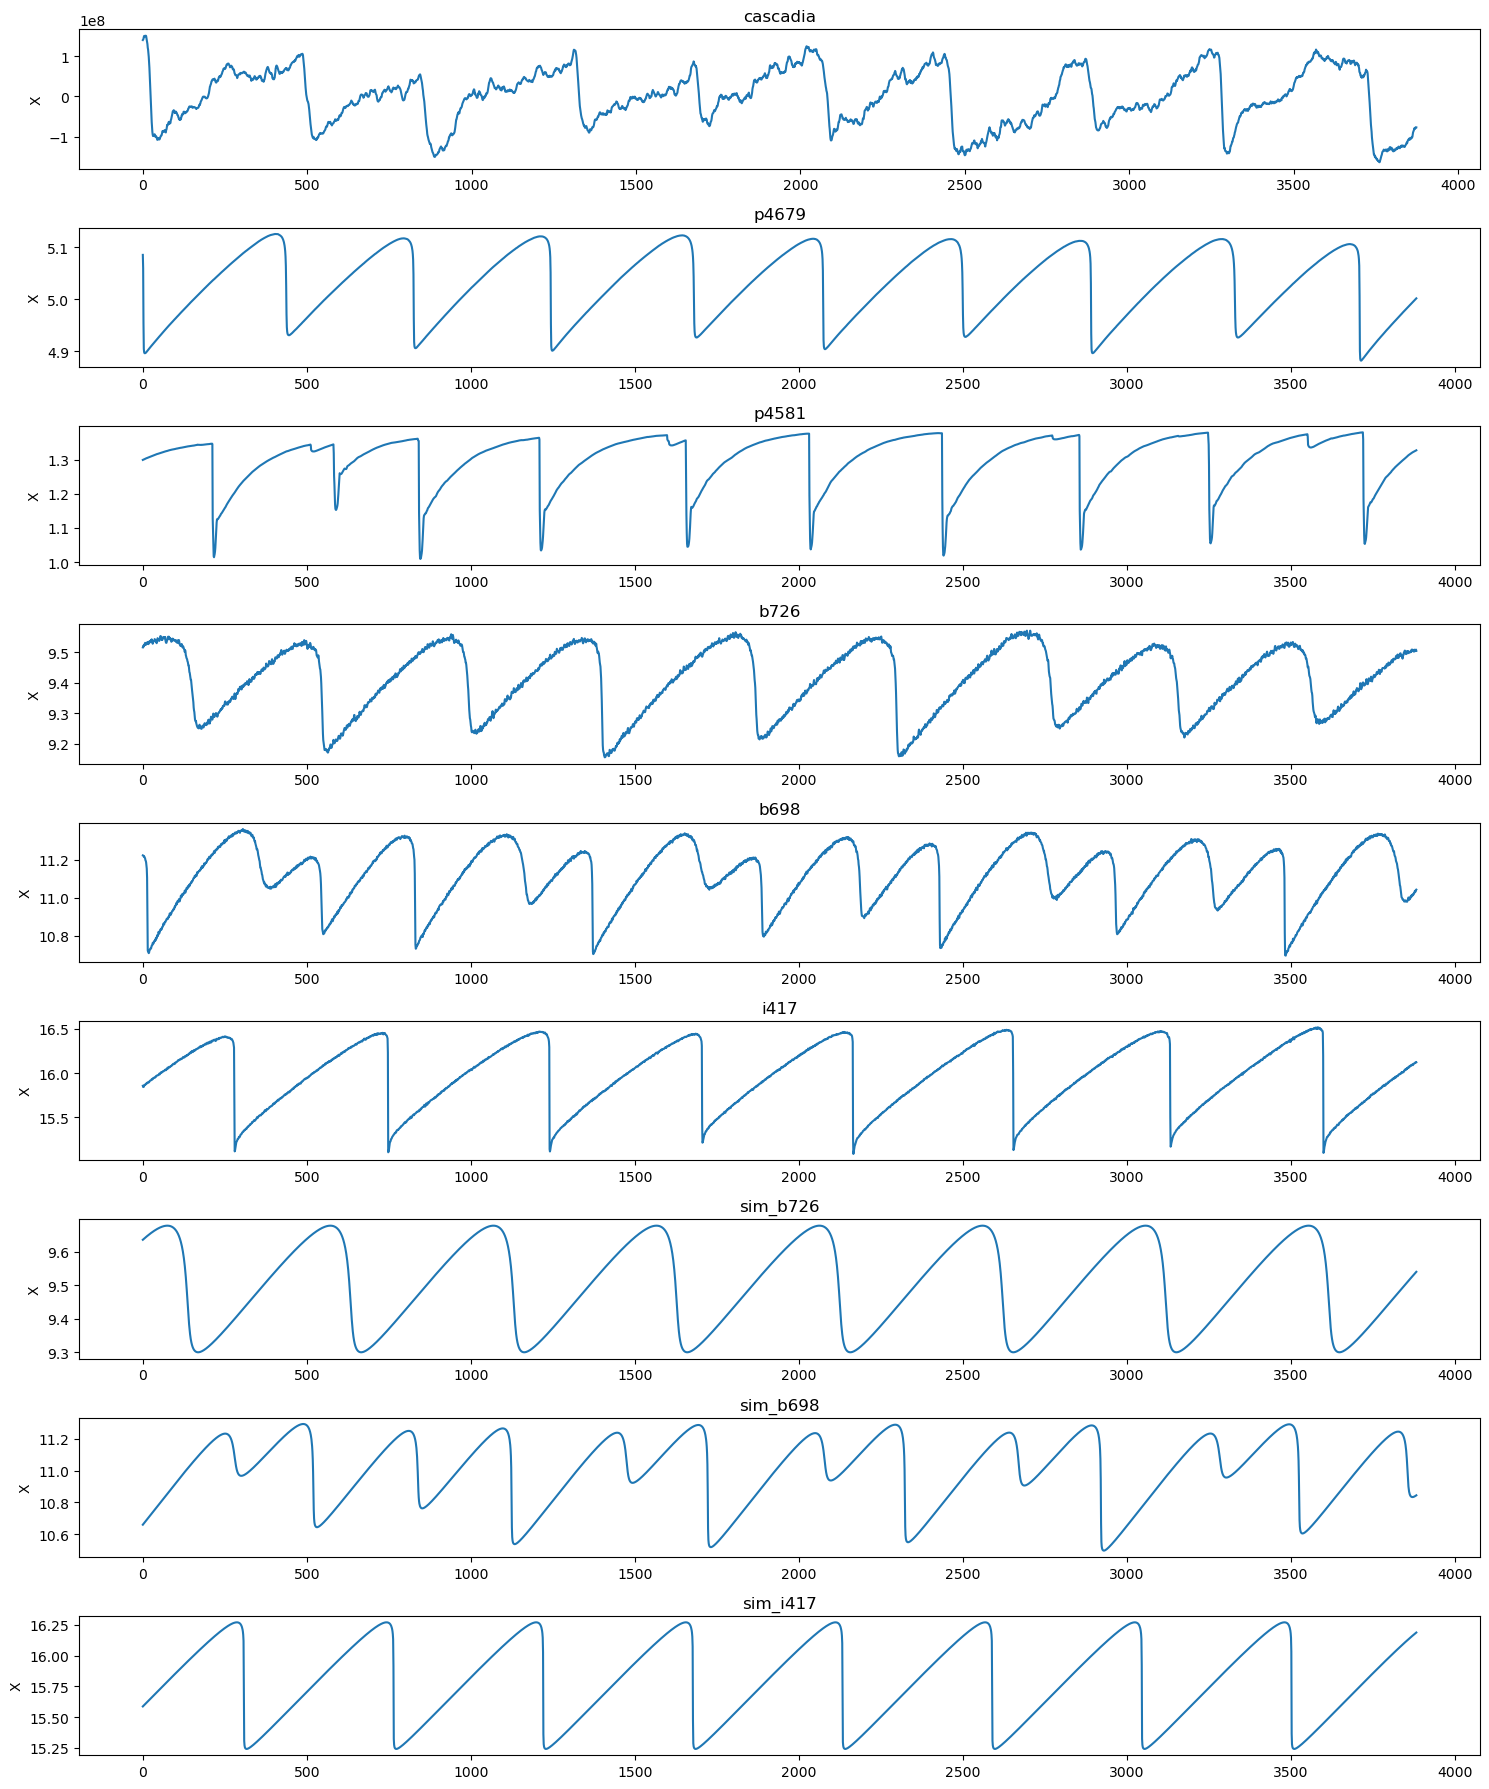

In [33]:
# Plot pre-processed data (smoothed and downsampled)

## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_filtered.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y="X")  # Use the DataFrame index for x
    plt.title(exp)


plt.tight_layout()
plt.show()


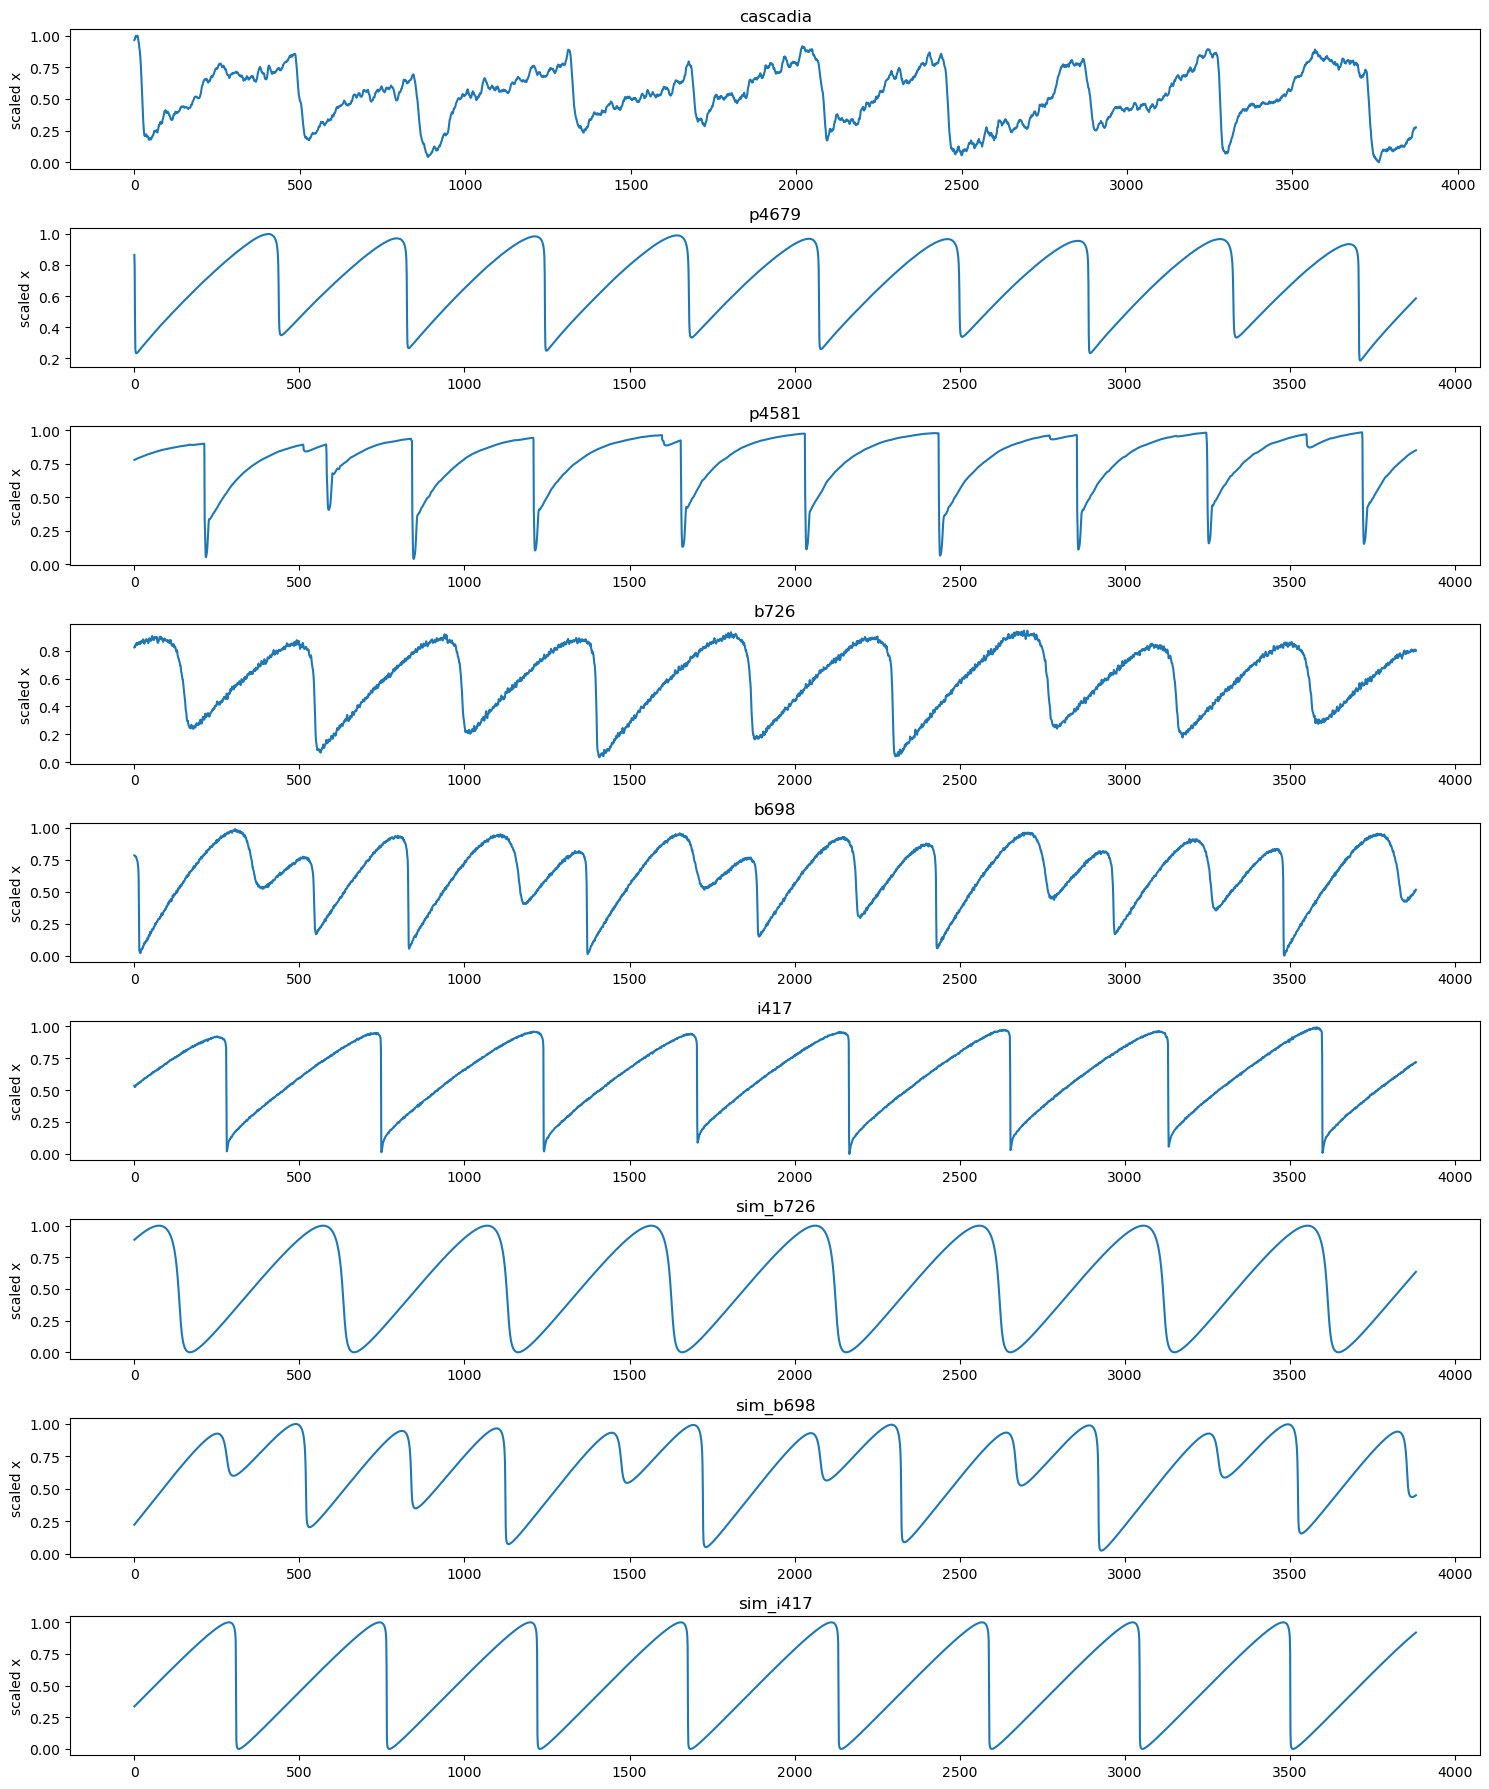

In [96]:
# Plot preprocessed and scaled data
## Truncate length of all arrays to match the length of 'cascadia' array
cascadia_length = len(df["cascadia"])
df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in df_filtered_sc.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    y_values = data[:, 0]  # Assuming you want to plot the first column
    x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(x=x_values, y=y_values)  # Plotting NumPy array directly
    plt.title(exp)
    plt.ylabel('scaled x')


plt.tight_layout()
plt.show()


## Full dataset derivatives

### Additional Smoothing

Using df_filtered_sc as a starting point since these are the datapoints that will be inputed into the loss function

PROBLEM: 
- Extra_smoothing_window has to be comparable to the forecast length before signal looks sufficiently smoothed - this would make calculating derivatives based on windwowed y_true and y_pred comparisons problematic because of large edge effects
- This is mostly a problem for Cascadia, a smaller extra_smoothing_window should be fine for the other datasets


In [86]:
# Trying out extra smoothing windows
EXTRA_SMOOTHING_WINDOW = 5 # set to 5 for now...
MIN_PERIODS = 1 # setting this to 1 prevents missing values when window overlaps with boundaries (there will still be boundary effects though)

df_extra_smooth = {
    exp: pd.DataFrame(df_filtered_sc[exp].flatten()).rolling(EXTRA_SMOOTHING_WINDOW, MIN_PERIODS, center=True).mean()
    for exp in EXPERIMENTS
}



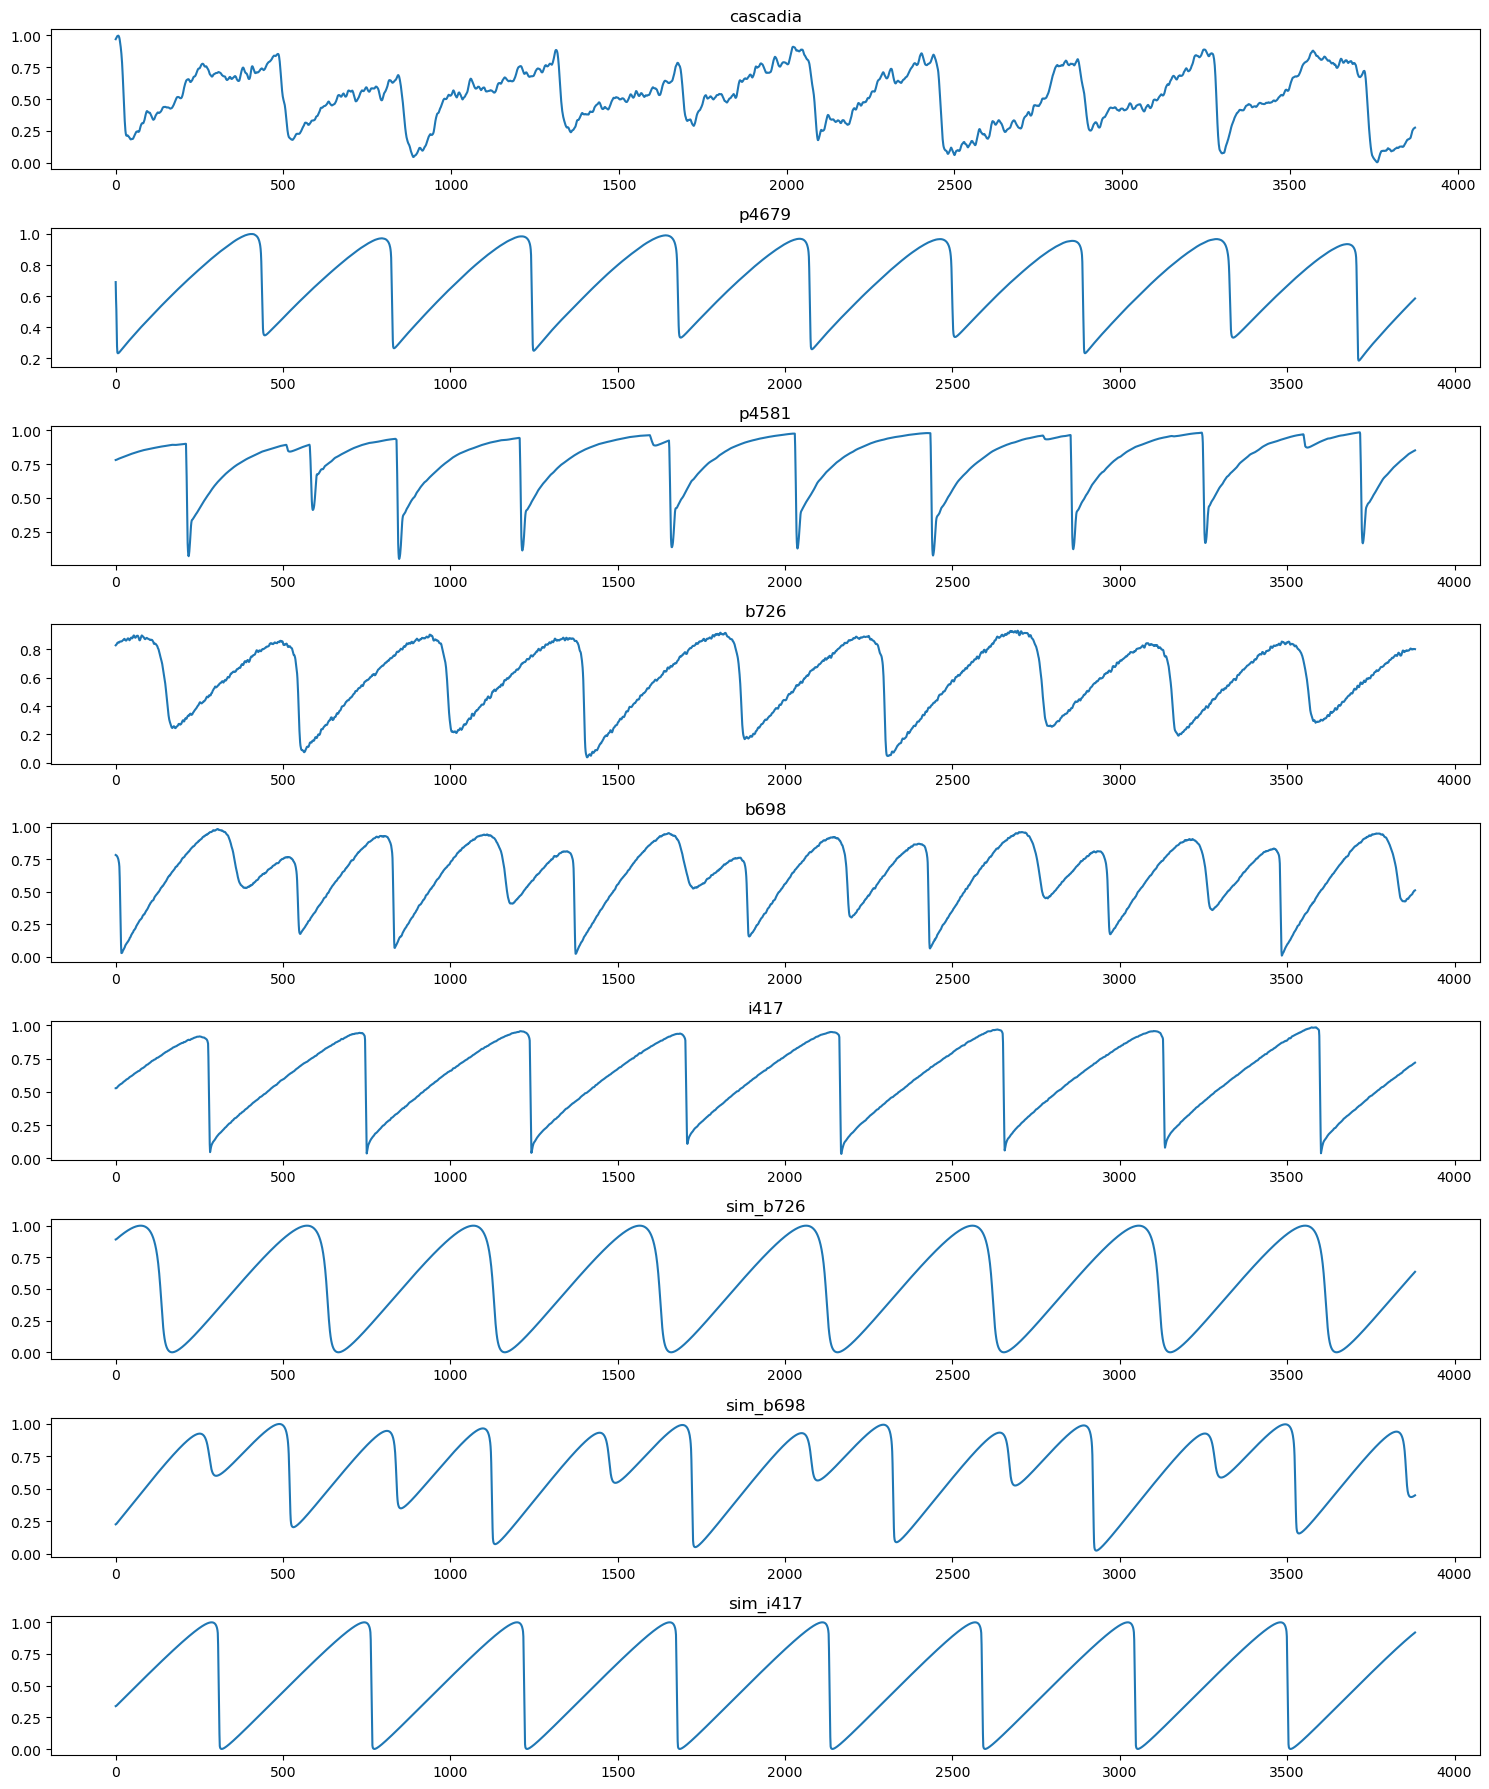

In [87]:
# Plot extra smoothed data
## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_extra_smooth.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y=data.columns[1])  # Use the DataFrame index for x
    plt.title(exp)
    plt.ylabel('')

plt.tight_layout()
plt.show()

### Calculate derivatives

In [88]:
# Calculate first derivative
first_derivative = {
    exp: np.gradient(df_extra_smooth[exp][0])
    for exp in EXPERIMENTS
}

In [89]:
# Calculate second derivative
second_derivative = {
    exp: np.gradient(first_derivative[exp])
    for exp in EXPERIMENTS
}

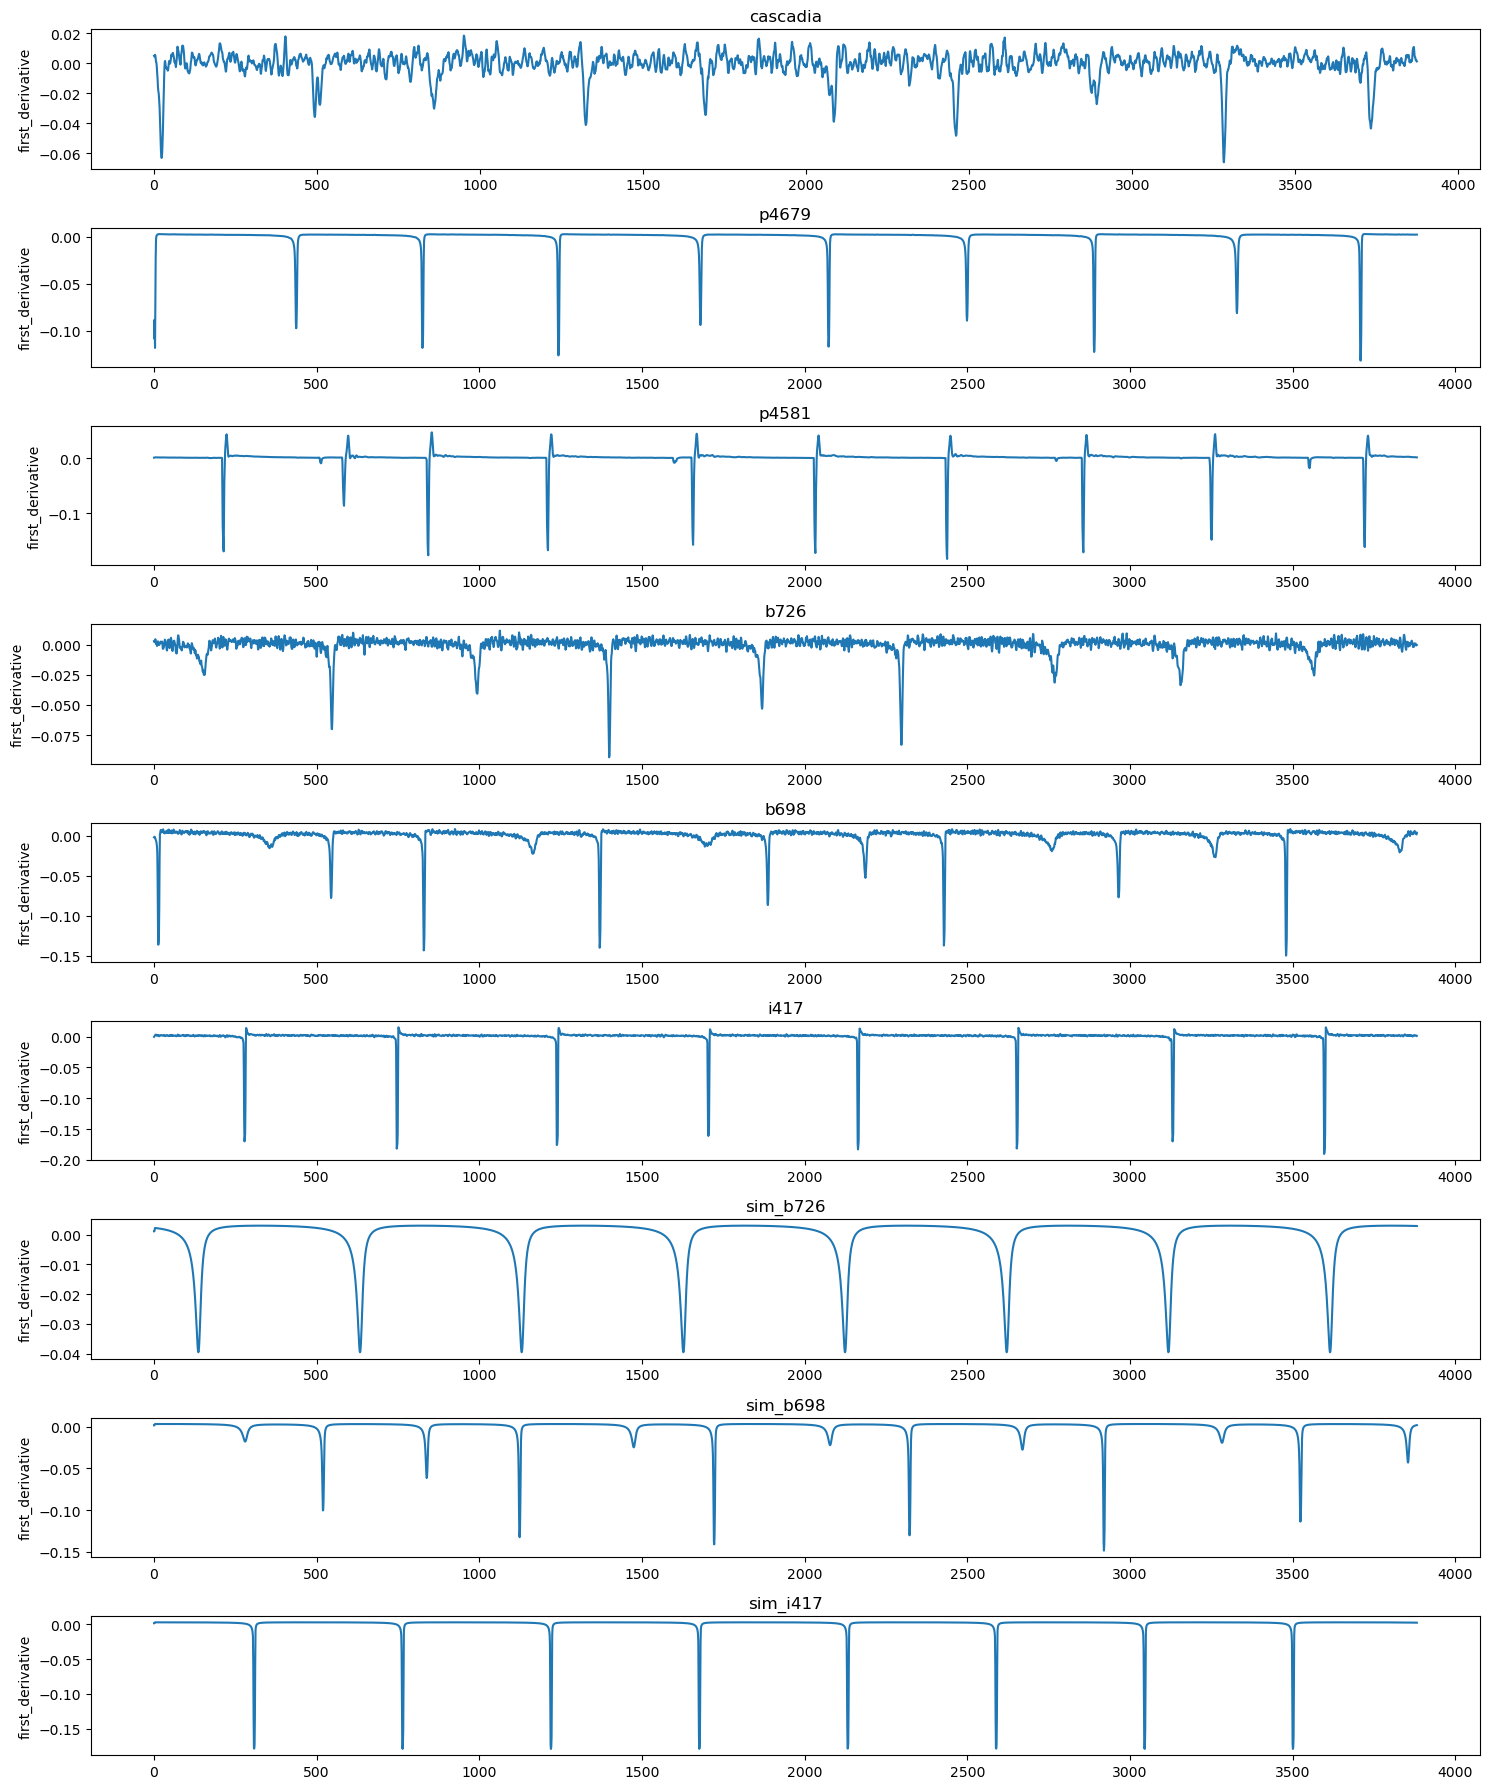

In [90]:
# Plot first derivative
## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in first_derivative.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    y_values = data  # Assuming you want to plot the first column
    x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(x=x_values, y=y_values)  # Plotting NumPy array directly
    plt.title(exp)
    plt.ylabel('first_derivative')

plt.tight_layout()
plt.show()

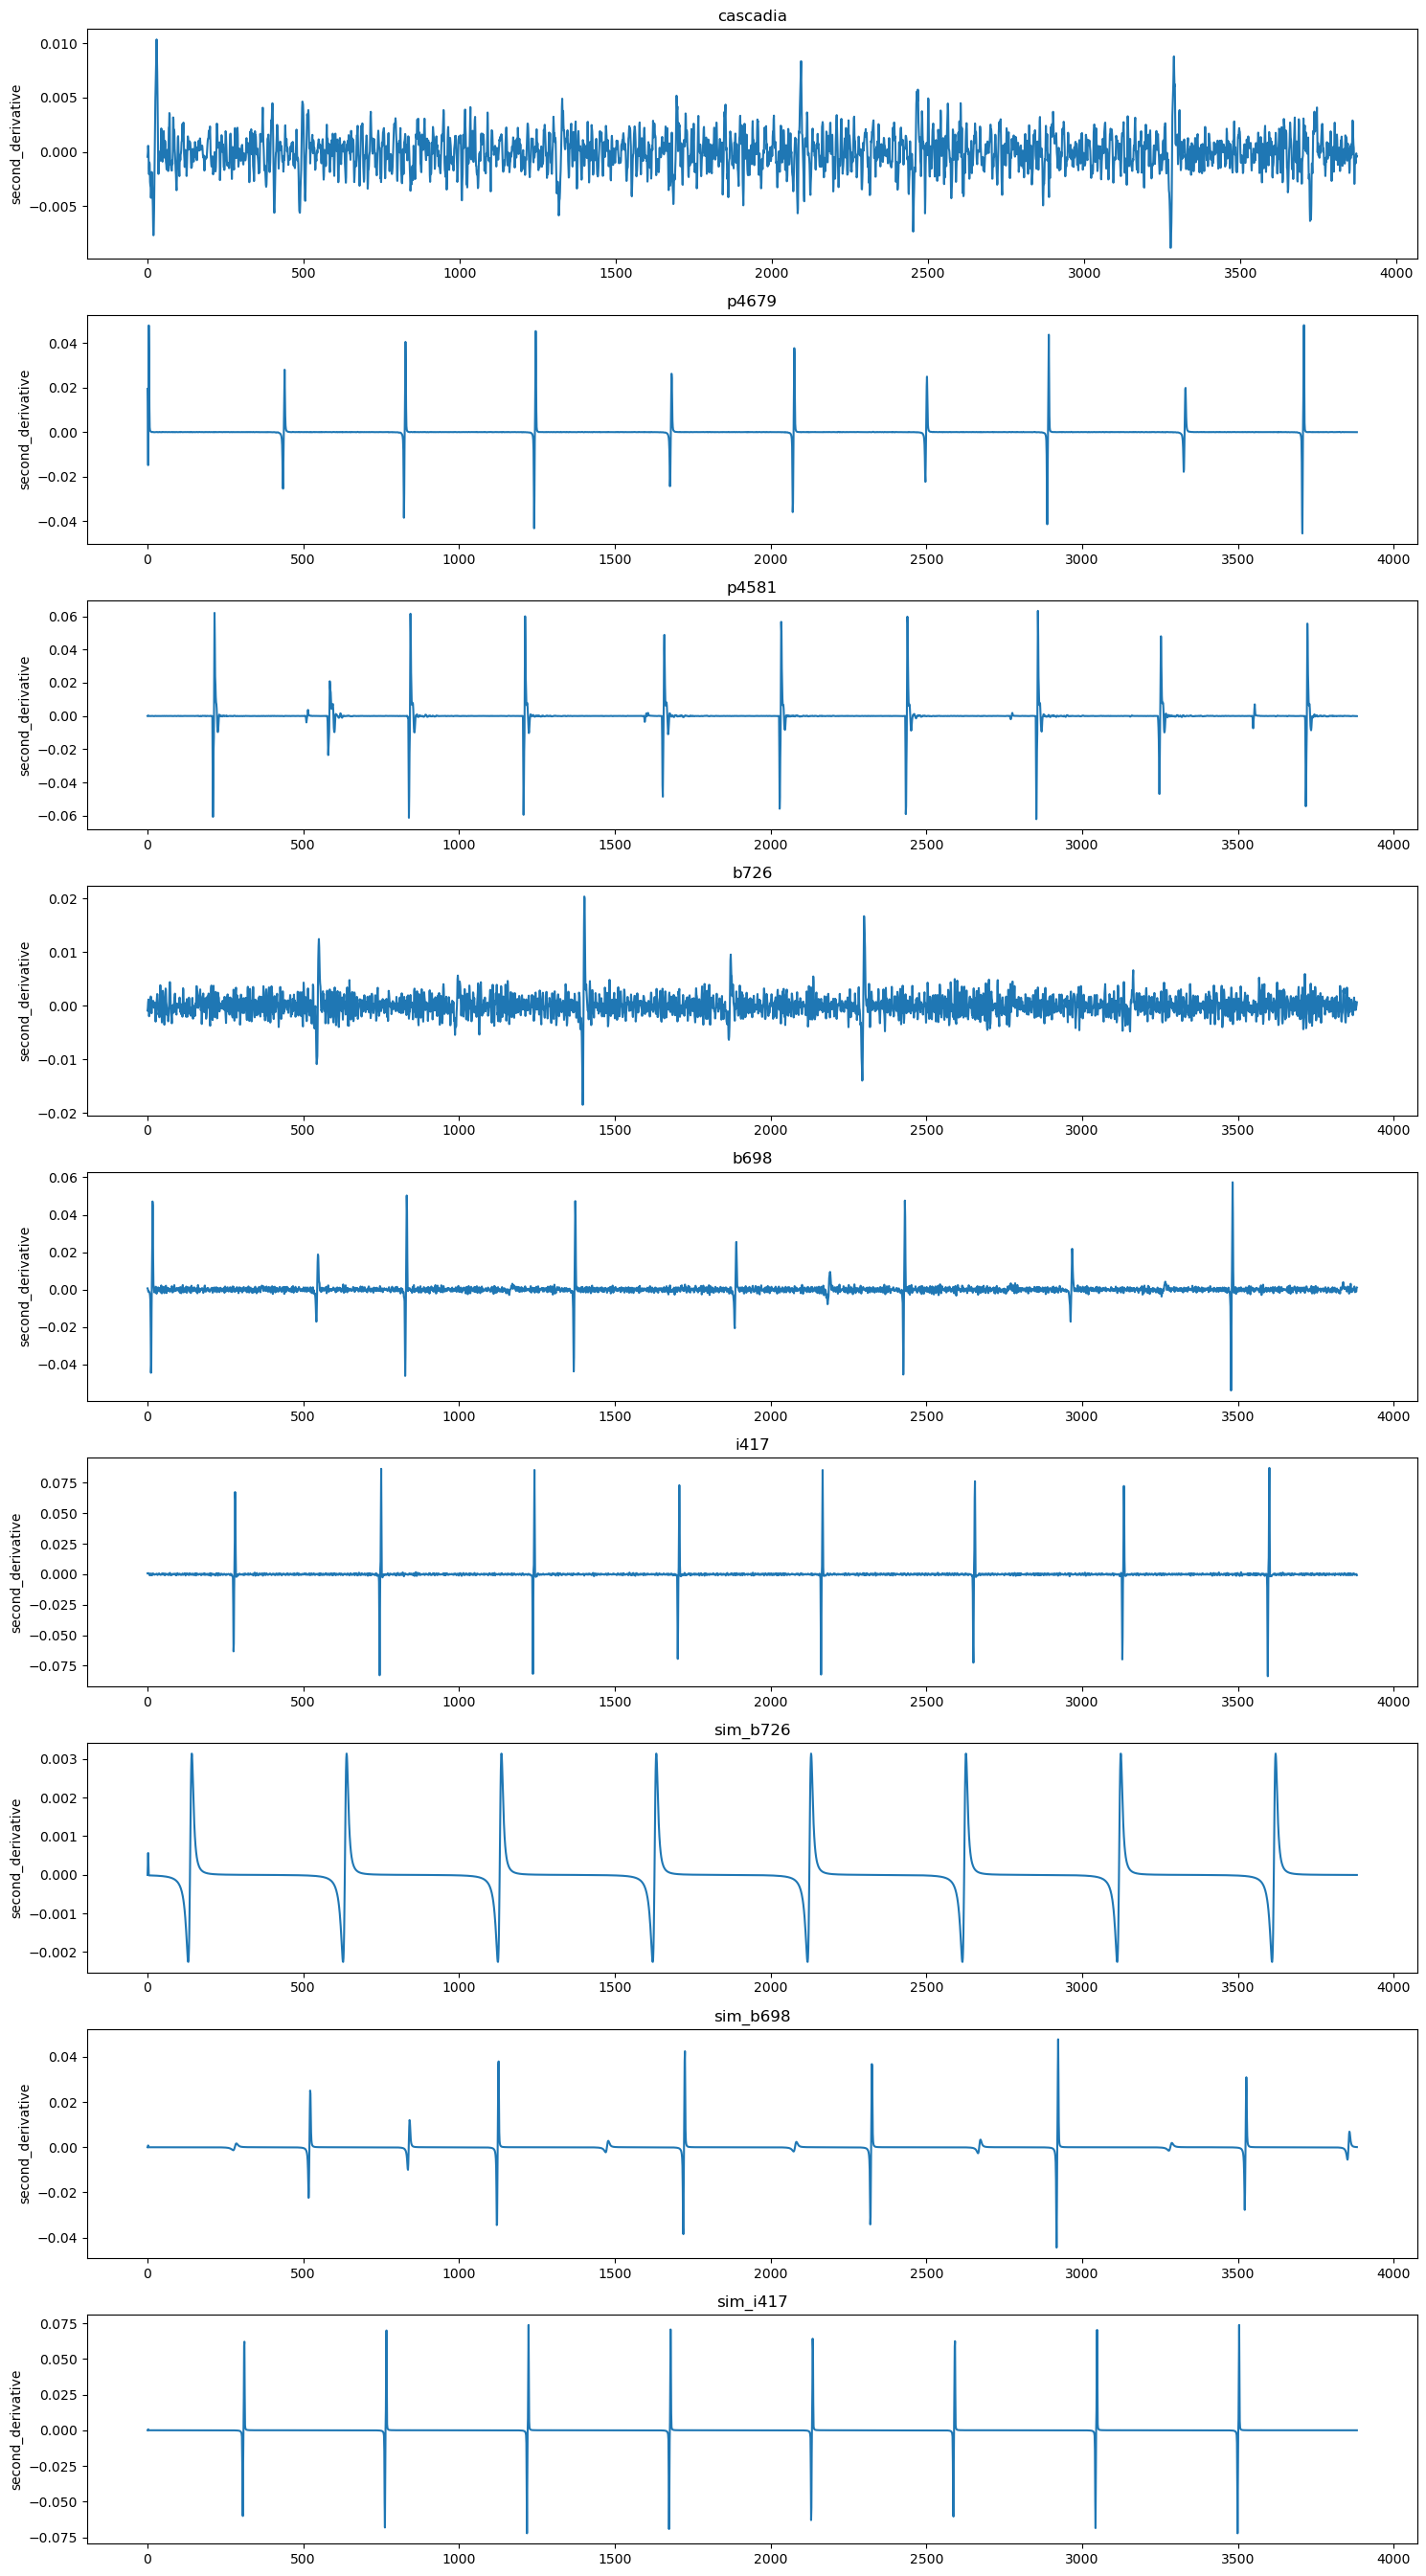

In [95]:
# Plot second derivative
## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in second_derivative.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 3))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    y_values = data  # Assuming you want to plot the first column
    x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(x=x_values, y=y_values)  # Plotting NumPy array directly
    plt.title(exp)
    plt.ylabel('second_derivative')

plt.tight_layout()
plt.show()

### Histograms of second derivative

In [ ]:
# Second derivative
plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    sns.histplot(second_derivative[exp])
    plt.title(exp)
    plt.xlabel("second derivative")

plt.tight_layout()
plt.show()

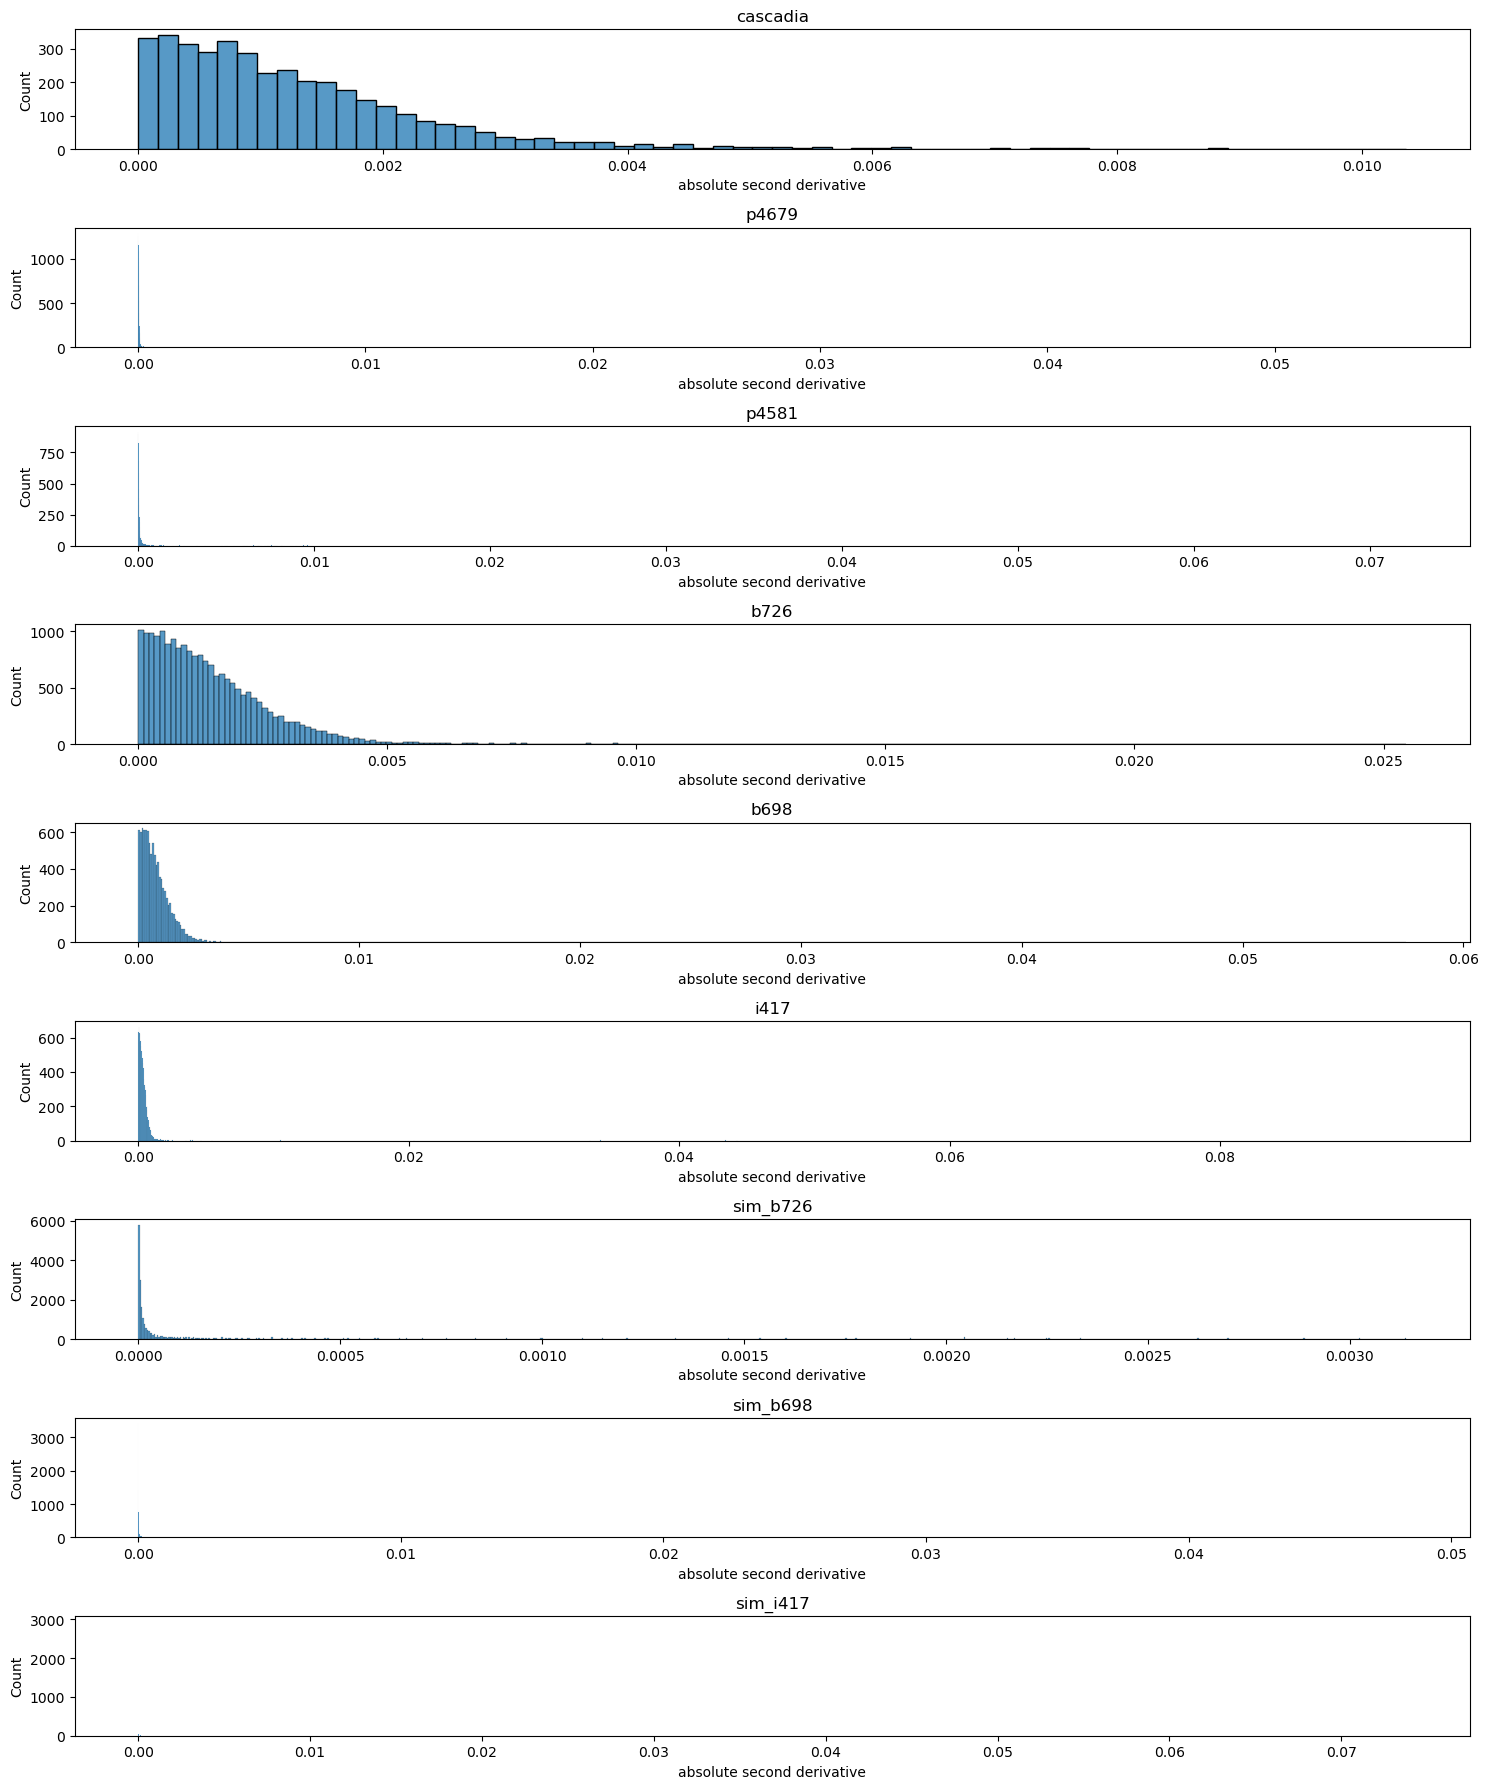

In [47]:
# Absolute second derivative
abs_second_derivative = {
    exp: abs(second_derivative[exp]) 
    for exp in EXPERIMENTS
    }

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    sns.histplot(abs_second_derivative[exp])
    plt.title(exp)
    plt.xlabel("absolute second derivative")

plt.tight_layout()
plt.show()


/tmp/ipykernel_78769/3872860944.py:3: RuntimeWarning: divide by zero encountered in log
  exp: np.log(abs(second_derivative[exp]))


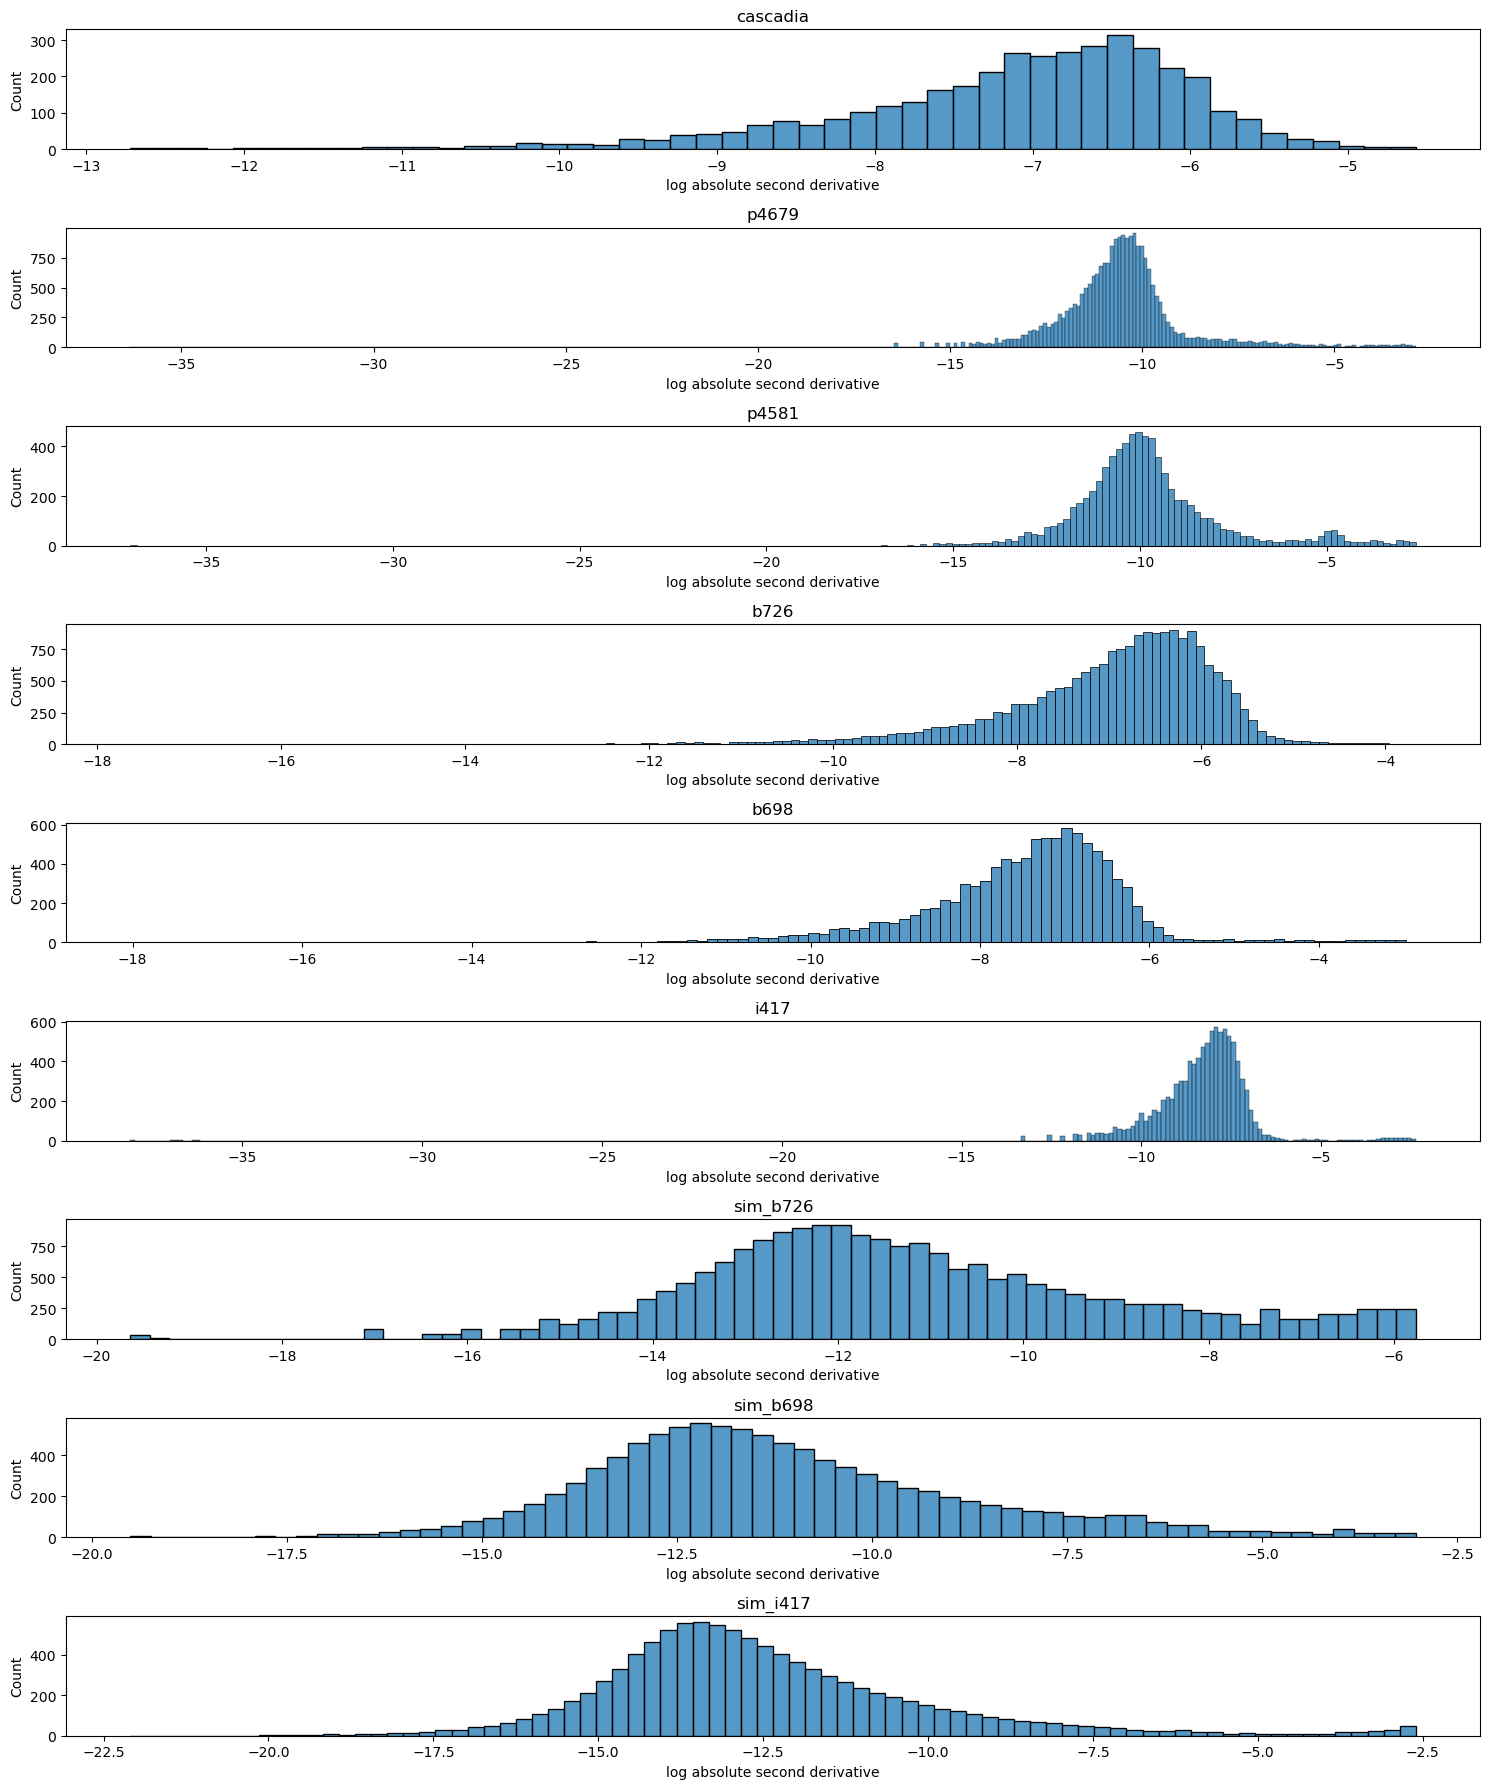

In [49]:
# Log absolute second derivative
log_abs_second_derivative = {
    exp: np.log(abs(second_derivative[exp])) 
    for exp in EXPERIMENTS
    }

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    sns.histplot(log_abs_second_derivative[exp])
    plt.title(exp)
    plt.xlabel("log absolute second derivative")

plt.tight_layout()
plt.show()

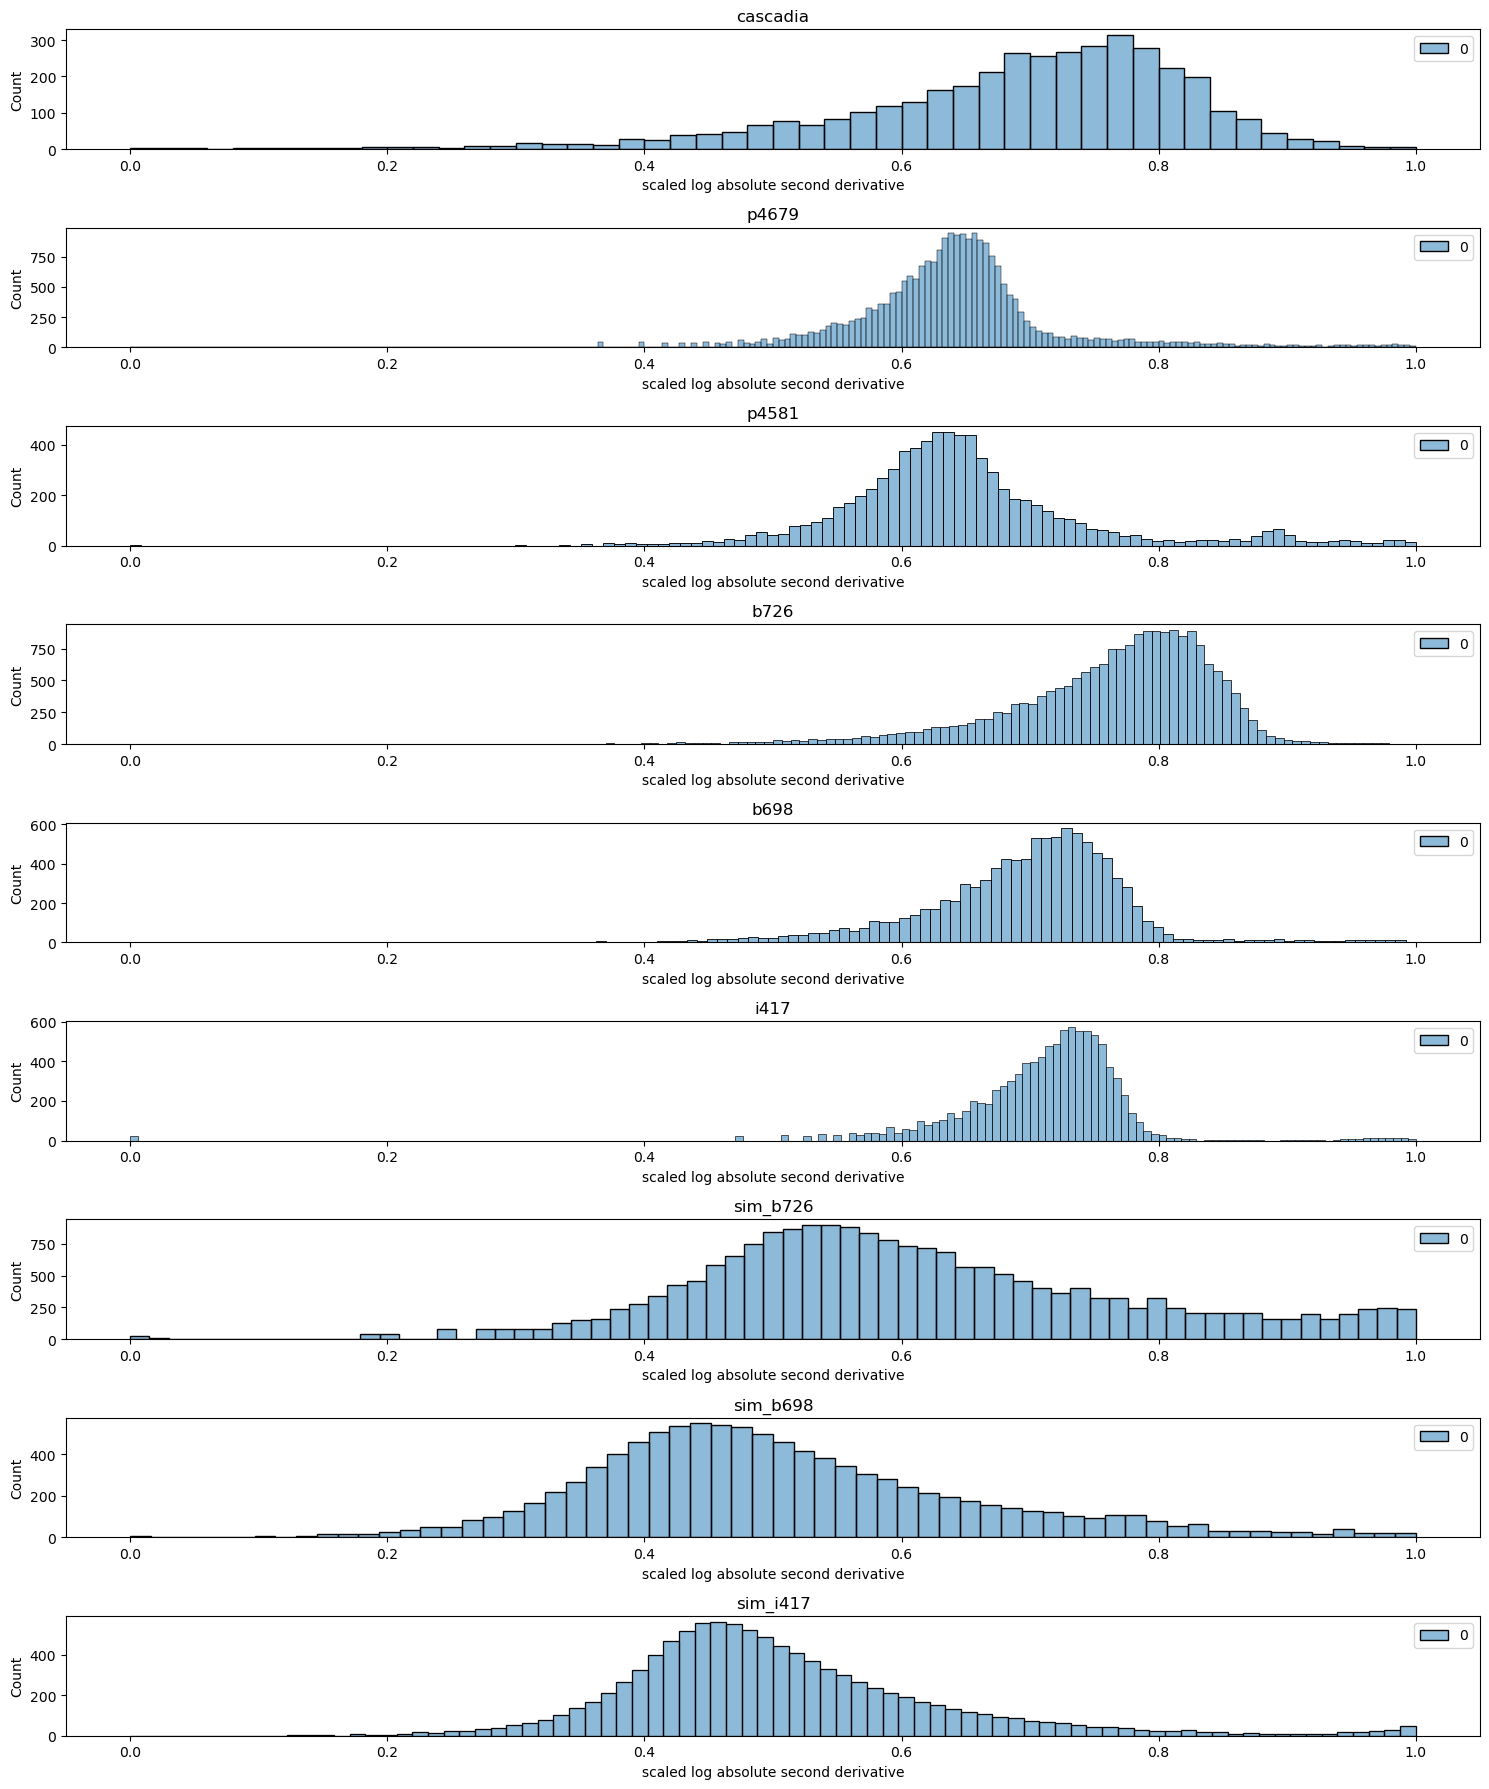

In [92]:
# Scaled log absolute derivative
scaler = MinMaxScaler()

sc_log_abs_second_derivative = {
    exp: scaler.fit_transform(np.log(abs(second_derivative[exp]+1e-10)).reshape(-1,1))
    for exp in EXPERIMENTS
    }

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    sns.histplot(sc_log_abs_second_derivative[exp])
    plt.title(exp)
    plt.xlabel("scaled log absolute second derivative")

plt.tight_layout()
plt.show()




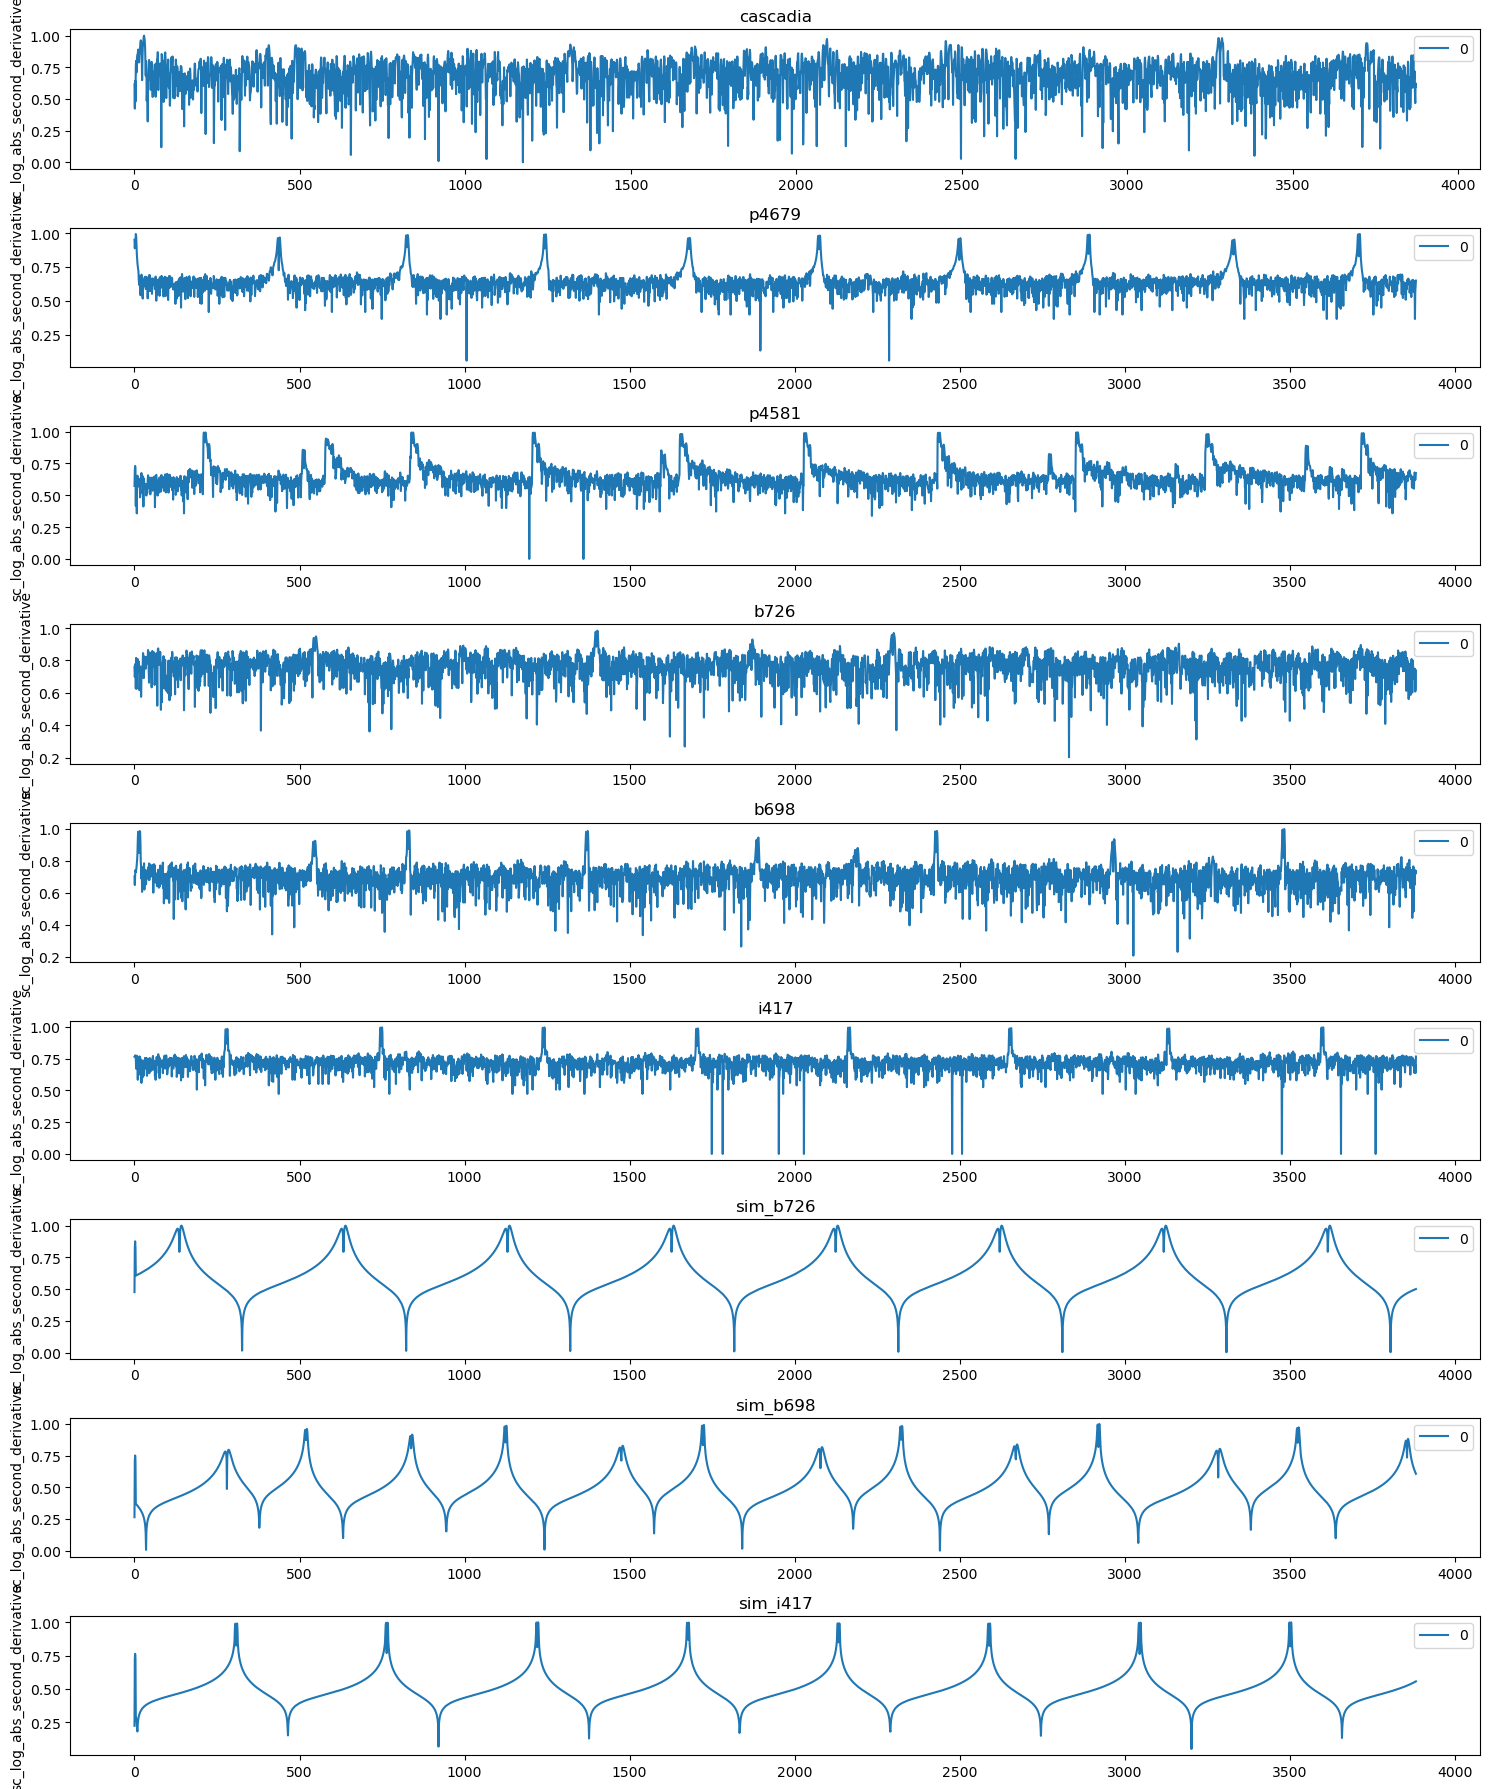

In [93]:
# Plot of scaled log absolute second derivative through time
df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in sc_log_abs_second_derivative.items()}

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    # y_values = data  # Assuming you want to plot the first column
    # x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(data)  # Plotting NumPy array directly
    plt.title(exp)
    plt.ylabel('sc_log_abs_second_derivative')

plt.tight_layout()
plt.show()


## Windowed datasets

In [ ]:
# Create datasets (use create_dataset)

In [ ]:
# Data scaling (use normalise_dataset)

## Custom loss function



Additional inputs to add to function: 
- extra smoothing window (or just dataset name and have these defined in the function)
- derivative scaling parameters (again could have these defined in the function based on datatset name)


Should square root be applied at the end??


In [35]:
# Custom loss function where weightings are simply 1 + abs(second_derivative)
def custom_loss1(y_true, y_pred, extra_smoothing_window):
    """
    Description
    """
    import torch
    import numpy as np

    # Calculate squared errors
    square_error = (y_true - y_pred)**2

    # Calculate second derivatives with extra smoothing
    y_true_smooth = y_true.rolling(extra_smoothing_window, 1, center=True).mean()
    first_derivative = np.gradient(y_true_smooth)
    second_derivative = np.gradient(first_derivative)

    # Calculate weighted loss from square error and second derivative
    weighted_loss = torch.mean(square_error * (1 + abs(second_derivative)))

    return weighted_loss


In [ ]:
# Custom loss function with more complex transformation and scaling of second derivative
def custom_loss2(y_true, y_pred, extra_smoothing_window, exp):
    """
    Description
    """
    import torch
    import numpy as np

    # Calculate squared errors
    square_error = (y_true - y_pred)**2

    # Calculate second derivatives with extra smoothing
    y_true_smooth = y_true.rolling(extra_smoothing_window, 1, center=True).mean()
    first_derivative = np.gradient(y_true_smooth)
    second_derivative = np.gradient(first_derivative)

    weightings = ... # scaling function for second derivative using experiment specific parameters (could be something like sc_log_abs_second_derivative above)

    # Calculate weighted loss from square error and second derivative
    weighted_loss = torch.mean(square_error * weightings)

    return weighted_loss


## Testing implementation